In [242]:
# My goal for this assignment is to better understand the geographic distribution of LA's implemented slow streets.

# I will be merging my slow streets data with zip codes to compile a count of how each zip code within LA is ranking.

In [557]:
# Import commands
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
from sodapy import Socrata
import seaborn as sns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy as np

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

In [558]:
# Import our data layers

streetsLA= gpd.read_file('Implemented_Slow_Streets.geojson')
walkLA= gpd.read_file('WalkLA150min.geojson')
parksLA= gpd.read_file('Recreation_and_Parks.geojson')
LAzips = gpd.read_file('LA_Zips.geojson')
LAzips2 = gpd.read_file('LA_Zips.geojson')
agendaLA = gpd.read_file('Agendized.geojson')
supportLA = gpd.read_file('Support.geojson')
parkpoints = gpd.read_file('park_points.geojson')

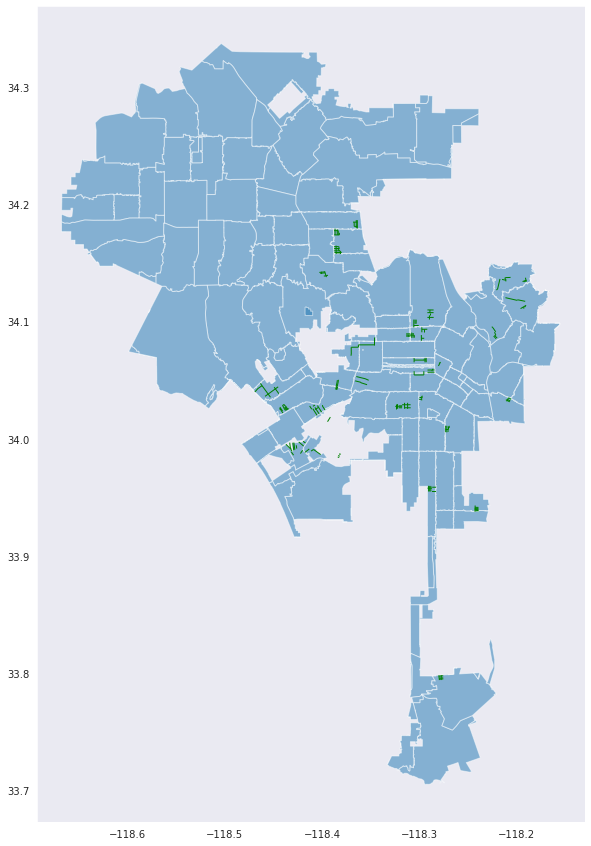

In [559]:
# Overlay comparison of zip codes to slow streets implemented

fig,ax = plt.subplots(figsize=(15,15))

LAzips.plot(ax=ax,zorder=10,alpha=0.5)

streetsLA.plot(ax=ax,color='green',zorder=10,lw=1)

In [560]:
# I would like to trim and relabel the columns of my slow streets data set.

streetsLA = streetsLA[['name', 'description','geometry']]

In [561]:
streetsLA.columns = ['Street Name', 'Neighborhood', 'geometry']

In [562]:
# What is the alphabetical order of the neighborhoods with slow streets?

streetsLA.sort_values(by='Neighborhood').head(20)

,Street Name,Neighborhood,geometry
135,22nd,Adams-Normandie,"LINESTRING Z (-118.29649 34.03638 0.00000, -11..."
137,23rd,Adams-Normandie,"LINESTRING Z (-118.30028 34.03546 0.00000, -11..."
138,25th,Adams-Normandie,"LINESTRING Z (-118.30021 34.03371 0.00000, -11..."
136,Raymond,Adams-Normandie,"LINESTRING Z (-118.29755 34.03635 0.00000, -11..."
142,Oregon St\n,Boyle Heights,"LINESTRING Z (-118.21095 34.03339 0.00000, -11..."
141,Guirado,Boyle Heights,"LINESTRING Z (-118.20916 34.03355 0.00000, -11..."
140,6th St\n,Boyle Heights,"LINESTRING Z (-118.20548 34.03376 0.00000, -11..."
139,Camulos St\n,Boyle Heights,"LINESTRING Z (-118.20818 34.03503 0.00000, -11..."
149,McConnell Blvd,Culver City,"LINESTRING Z (-118.43335 33.99677 0.00000, -11..."
153,Sumner Way,Culver City,"LINESTRING Z (-118.38398 33.98438 0.00000, -11..."


In [563]:
# The data begins with Adams/Normandie at the start of the list.

In [564]:
# reproject to web mercator
streetsLA = streetsLA.to_crs(epsg=3857)
LAzips = LAzips.to_crs(epsg=3857)
LAzips2 = LAzips2.to_crs(epsg=3857)


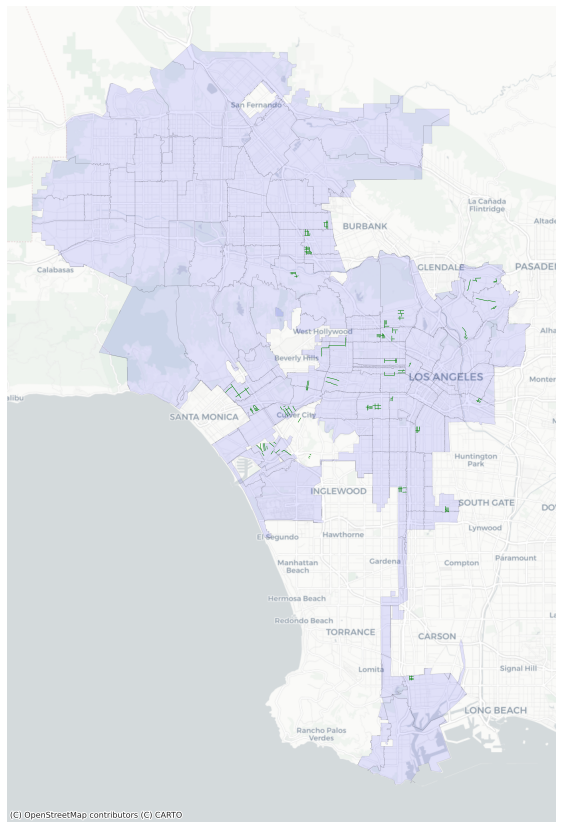

In [565]:
# plot with the nicer basemap at correct scale
fig, ax = plt.subplots(figsize=(15,15))

streetsLA.plot(ax=ax,
         color='green', 
         edgecolor='white',
         lw=0.5,
         alpha=1)

LAzips.plot(ax=ax,
         color='blue', 
         edgecolor='black',
         lw=0.5,
         alpha=0.1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [566]:
# We need to join the LA streets data with its designated zip code

join = gpd.sjoin(streetsLA, LAzips, how='left')
join.head()

,Street Name,Neighborhood,geometry,index_right,OBJECTID,CITY,ZIPCODE,ZIP,TOOLTIP,NLA_URL,AnalysisArea
0,S Westgate Ave,Sawtelle,"LINESTRING (-13187300.728 4035155.971, -131861...",22.0,23.0,IN,90025,90025.0,Zip Code: 90025,n,2.413864
1,Lindblade Dr,Del Rey,"LINESTRING (-13182911.178 4028447.410, -131823...",54.0,55.0,IN,90066,90066.0,Zip Code: 90066,n,4.508144
2,Nebraska Ave,Sawtelle,"LINESTRING (-13186763.834 4033673.779, -131852...",22.0,23.0,IN,90025,90025.0,Zip Code: 90025,n,2.413864
3,Texas St,Sawtelle,"LINESTRING (-13187111.485 4034893.184, -131875...",87.0,88.0,IN,90404,90404.0,Zip Code: 90404,n,0.007684
3,Texas St,Sawtelle,"LINESTRING (-13187111.485 4034893.184, -131875...",22.0,23.0,IN,90025,90025.0,Zip Code: 90025,n,2.413864


In [567]:
# How many slow streets does each zipcode have?

streets_count = join['ZIPCODE'].value_counts()
streets_count = streets_count.reset_index()
streets_count.describe()

,ZIPCODE
count,35.000000
mean,5.371429
std,3.589902
min,1.000000
25%,2.500000
50%,4.000000
75%,7.500000
max,16.000000


In [568]:
# The average zip code has about 5 slow streets implemented. The highest is 16 and the lowest is only 1 slow street.

In [569]:
# Let's relabel the streets_count column

streets_count.columns = ['ZIPCODE', 'Count']
streets_count.head()

,ZIPCODE,Count
0,91601,16
1,90029,13
2,90034,10
3,90018,10
4,90027,10


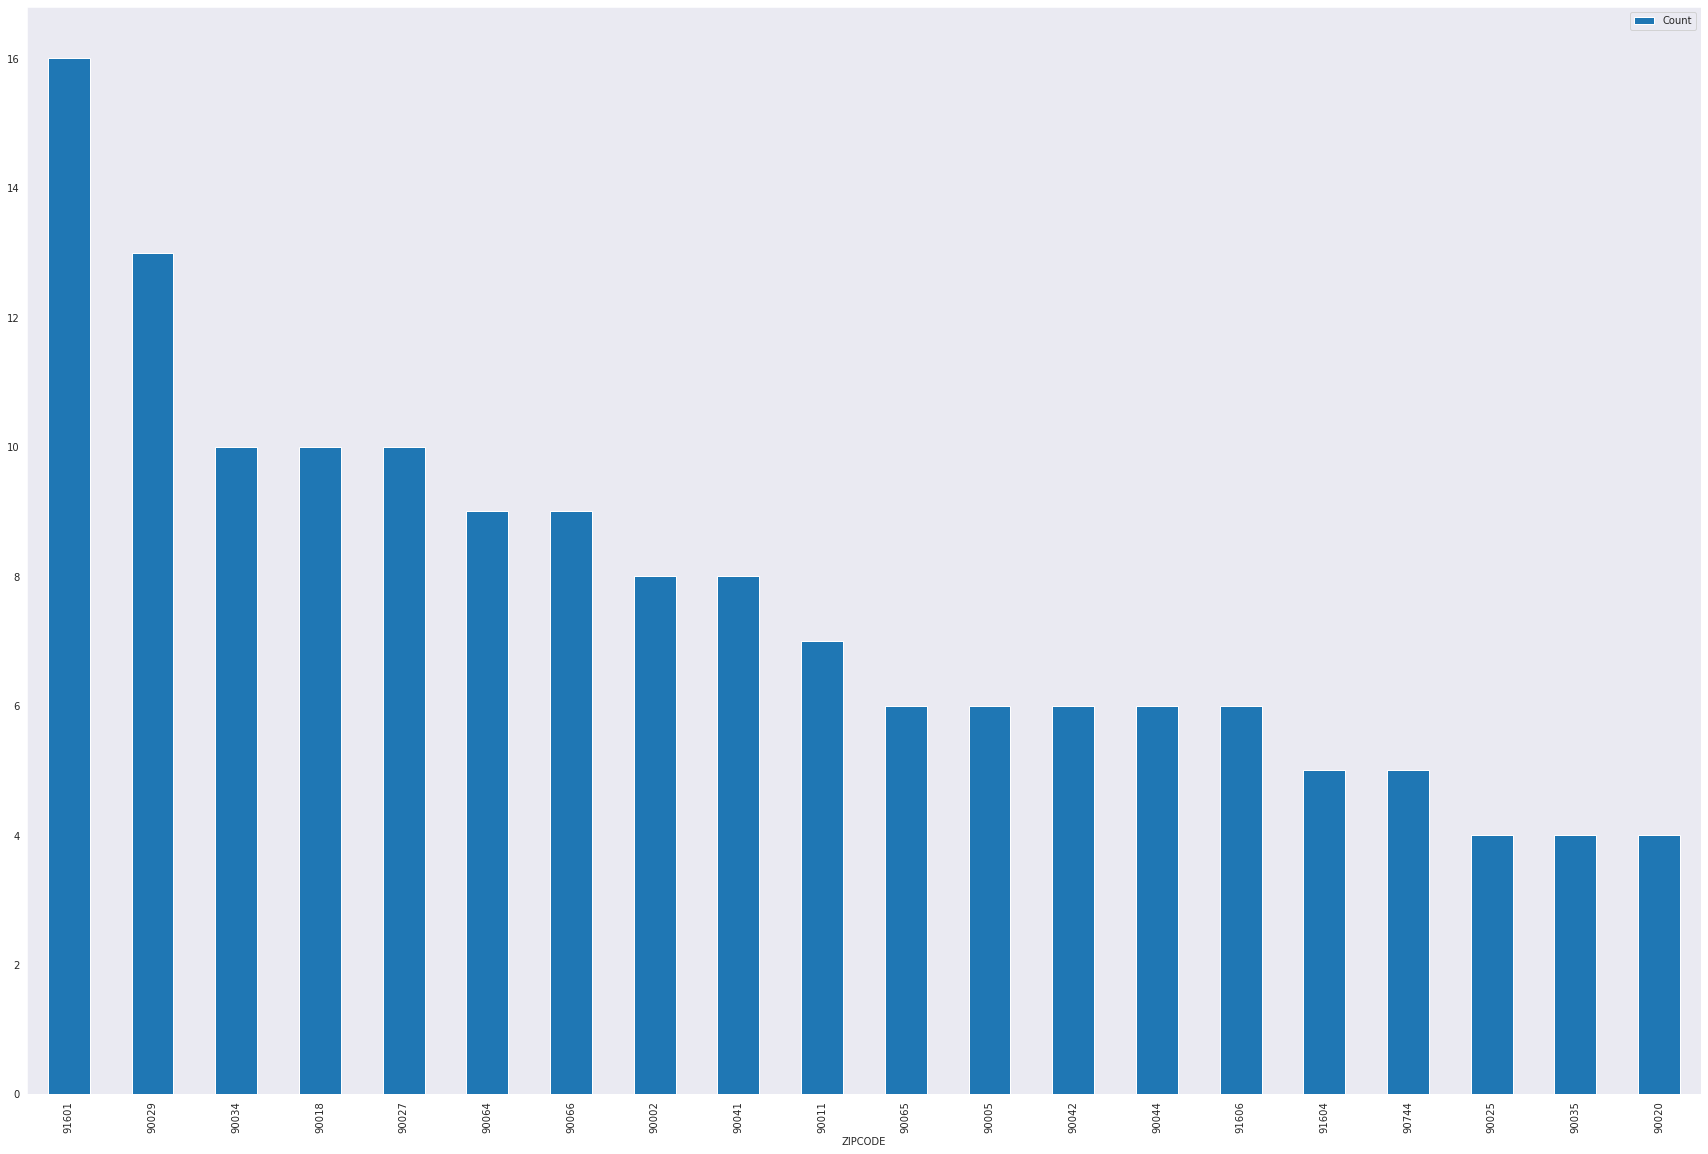

In [570]:
# Graph the slow streets data by zip code

streets_count[:20].plot.bar(figsize=(30,20),
                             x='ZIPCODE',
                             y='Count')

In [571]:
# Let's drop only the columns we need for the join
join = join[['Street Name', 'Neighborhood', 'geometry', 'ZIPCODE']]
join.head()

,Street Name,Neighborhood,geometry,ZIPCODE
0,S Westgate Ave,Sawtelle,"LINESTRING (-13187300.728 4035155.971, -131861...",90025
1,Lindblade Dr,Del Rey,"LINESTRING (-13182911.178 4028447.410, -131823...",90066
2,Nebraska Ave,Sawtelle,"LINESTRING (-13186763.834 4033673.779, -131852...",90025
3,Texas St,Sawtelle,"LINESTRING (-13187111.485 4034893.184, -131875...",90404
3,Texas St,Sawtelle,"LINESTRING (-13187111.485 4034893.184, -131875...",90025


In [572]:
# We now need to re-merge the data together.
# The zip code street counts need to be merged with the zip code data set to capture each geometry.

LAzips=LAzips.merge(streets_count,on='ZIPCODE')

In [573]:
# Which zip codes have the most slow streets?

LAzips.sort_values(by="Count").tail()

,OBJECTID,CITY,ZIPCODE,ZIP,TOOLTIP,NLA_URL,AnalysisArea,geometry,Count
13,31,IN,90034,90034,Zip Code: 90034,n,3.096348,"POLYGON ((-13176910.037 4034340.283, -13176910...",10
11,25,IN,90027,90027,Zip Code: 90027,n,8.632505,"POLYGON ((-13170058.384 4050496.579, -13170068...",10
6,17,IN,90018,90018,Zip Code: 90018,n,2.978121,"POLYGON ((-13169147.353 4034189.199, -13169177...",10
12,27,IN,90029,90029,Zip Code: 90029,n,1.428381,"POLYGON ((-13166452.835 4041673.329, -13166477...",13
31,149,IN,91601,91601,Zip Code: 91601,n,2.658032,"POLYGON ((-13175582.229 4052387.258, -13175648...",16


In [574]:
# The 91601 zip code (Valley Village) has the most at 16, followed by 90029 (East Hollywood)

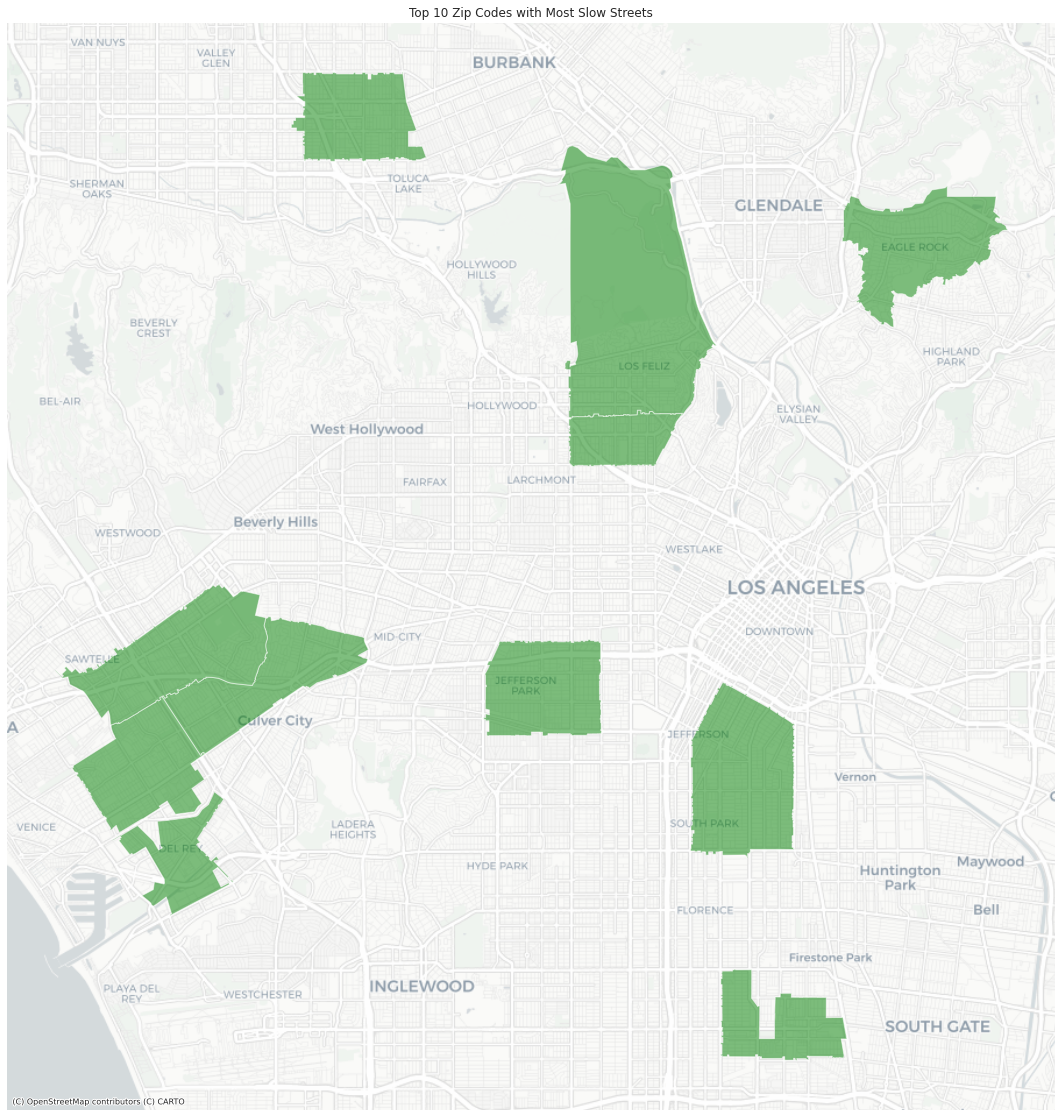

In [575]:
# Map the top 10 Zip Codes
fig,ax = plt.subplots(figsize=(20,20))
LAzips.sort_values(by='Count',ascending=False)[:10].plot(ax=ax,
                                                                 color='green',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top 10 Zip Codes with Most Slow Streets')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

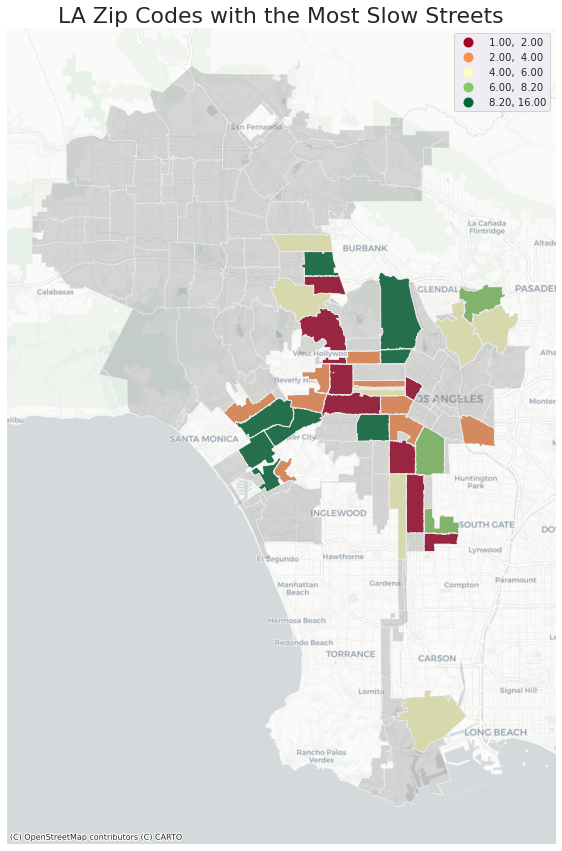

In [576]:
fig,ax = plt.subplots(figsize=(15,15))

LAzips.plot(ax=ax,
        column='Count',
        legend=True,
        alpha=1,
        cmap='RdYlGn',
        scheme='quantiles')


LAzips2.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.3)

ax.axis('off')
ax.set_title('LA Zip Codes with the Most Slow Streets',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [577]:
#Let's do some analysis on all the parks in LA. Iam no longer using park polygons from the midterm. Instead, let's use points.

In [578]:
parkpoints.head()

,OBJECTID_1,OBJECTID,AREA,PERIMETER,RP_FAC_,RP_FAC_ID,FACNAME,TOOLTIP,NLA_URL,RP_FAC1,...,MAINTDST,MISC,DTOWNR,REVDATE,URL,DESCRIP,FACPHONE,FAXPHONE,CATEGORY,geometry
0,1,1,0,0,1,1,Wattles Garden Park,Facility: Wattles Garden Park,navigatela/reports/recs_parks_facilities.cfm?pk=1,1,...,Griffith,,RAP,01/20/2000,,"Japanese Garden & Tea House, Public Vegetable ...",,,Parks,POINT (-118.35495 34.10463)
1,2,2,0,0,2,2,Yosemite Recreation Center,Facility: Yosemite Recreation Center,navigatela/reports/recs_parks_facilities.cfm?pk=2,2,...,Arroyo Seco,,RAP,01/20/2000,,"Auditorium capacity: 200, One Diamond -Lighted...",(323)257-1644,,Recreational Centers,POINT (-118.20783 34.13361)
2,3,3,0,0,3,3,Yucca Park,Facility: Yucca Park,navigatela/reports/recs_parks_facilities.cfm?pk=3,3,...,MacArthur,,RAP,01/20/2000,,,,,Parks,POINT (-118.33543 34.10329)
3,4,4,0,0,4,4,Balboa Sports Center,Facility: Balboa Sports Center,navigatela/reports/recs_parks_facilities.cfm?pk=4,4,...,Sepulveda,,RAP,01/20/2000,,"Auditorium Capacity: 600, Community Room, Outd...",(818)756-9642,,Recreational Centers,POINT (-118.50173 34.17233)
4,5,5,0,0,5,5,Branford Recreation Center,Facility: Branford Recreation Center,navigatela/reports/recs_parks_facilities.cfm?pk=5,5,...,Valley Plaza,,RAP,01/20/2000,,"Auditorium Capacity: 600, Community Room, Indo...",(818)893-4923,,Recreational Centers,POINT (-118.42323 34.23349)


In [579]:
parkpoints.CATEGORY.value_counts()
#This tells us the types of park facilities there are

Recreational Centers    187
Parks                    45
Aquatics                 41
Sport Facilities         15
Name: CATEGORY, dtype: int64

In [580]:
parkpoints_10 = parkpoints.CATEGORY.value_counts().head(10).index.tolist()
parkpoints_10

['Recreational Centers', 'Parks', 'Aquatics', 'Sport Facilities']

In [581]:
parkpoints[parkpoints.CATEGORY == 'Recreational Centers'].head()

,OBJECTID_1,OBJECTID,AREA,PERIMETER,RP_FAC_,RP_FAC_ID,FACNAME,TOOLTIP,NLA_URL,RP_FAC1,...,MAINTDST,MISC,DTOWNR,REVDATE,URL,DESCRIP,FACPHONE,FAXPHONE,CATEGORY,geometry
1,2,2,0,0,2,2,Yosemite Recreation Center,Facility: Yosemite Recreation Center,navigatela/reports/recs_parks_facilities.cfm?pk=2,2,...,Arroyo Seco,,RAP,01/20/2000,,"Auditorium capacity: 200, One Diamond -Lighted...",(323)257-1644,,Recreational Centers,POINT (-118.20783 34.13361)
3,4,4,0,0,4,4,Balboa Sports Center,Facility: Balboa Sports Center,navigatela/reports/recs_parks_facilities.cfm?pk=4,4,...,Sepulveda,,RAP,01/20/2000,,"Auditorium Capacity: 600, Community Room, Outd...",(818)756-9642,,Recreational Centers,POINT (-118.50173 34.17233)
4,5,5,0,0,5,5,Branford Recreation Center,Facility: Branford Recreation Center,navigatela/reports/recs_parks_facilities.cfm?pk=5,5,...,Valley Plaza,,RAP,01/20/2000,,"Auditorium Capacity: 600, Community Room, Indo...",(818)893-4923,,Recreational Centers,POINT (-118.42323 34.23349)
5,6,6,0,0,6,6,Canoga Park Sr. Citizen Center,Facility: Canoga Park Sr. Citizen Center,navigatela/reports/recs_parks_facilities.cfm?pk=6,6,...,Valley West,,RAP,01/20/2000,,"Auditorium Capacity: 230, Community Room",(818)340-2633,,Recreational Centers,POINT (-118.60279 34.20335)
7,8,8,0,0,8,8,Delano Park,Facility: Delano Park,navigatela/reports/recs_parks_facilities.cfm?pk=8,8,...,Sepulveda,,RAP,01/20/2000,,"Auditorium Capacity: 100, Community Room, Indo...",(818)756-8529,,Recreational Centers,POINT (-118.46183 34.18295)


In [582]:
#Let's drop any null values and reset our columns

parkpoints.loc[parkpoints['CATEGORY']== 'NaN']
parkpoints.loc[parkpoints['FACNAME']== 'NaN']
parkpoints= parkpoints[['FACNAME','CATEGORY', 'geometry']]

In [583]:
parkpoints.tail()

,FACNAME,CATEGORY,geometry
283,Chosen-Ryu Karate Studio (Granada Hills Off Site),Recreational Centers,POINT (-118.51616 34.26496)
284,Iceoplex ( Granada Hills Off Site),Recreational Centers,POINT (-118.49404 34.22258)
285,Granada Hills High School( Granada Hills Off S...,Recreational Centers,POINT (-118.52348 34.26179)
286,University High School (Barrington Off Site),Recreational Centers,POINT (-118.46087 34.04598)
287,Montecito del Leo Politti,Parks,POINT (-118.25059 34.07611)


In [584]:
parkpoints = parkpoints.to_crs(epsg=3857)

,FACNAME,CATEGORY,geometry
1,Yosemite Recreation Center,Recreational Centers,POINT (-13158835.026 4046757.001)
3,Balboa Sports Center,Recreational Centers,POINT (-13191551.865 4051964.848)
4,Branford Recreation Center,Recreational Centers,POINT (-13182813.630 4060196.797)
5,Canoga Park Sr. Citizen Center,Recreational Centers,POINT (-13202801.922 4056139.475)
7,Delano Park,Recreational Centers,POINT (-13187111.127 4053394.290)


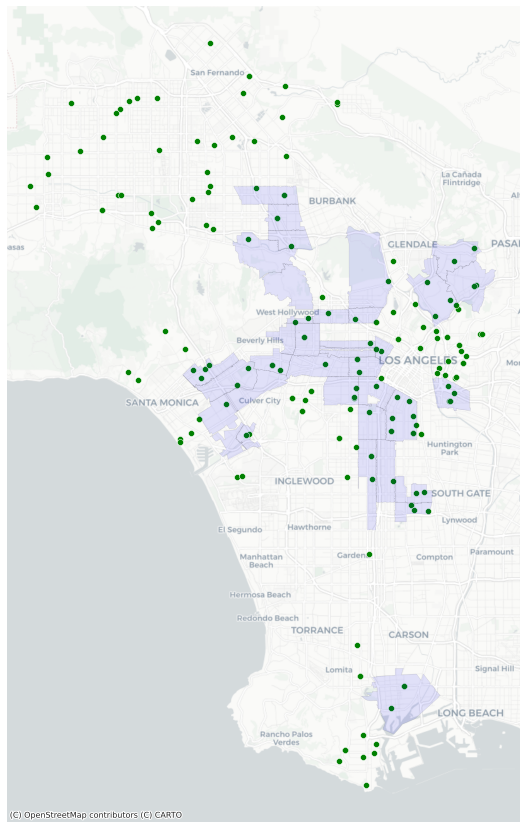

In [585]:
# table
display(parkpoints[parkpoints.CATEGORY == 'Recreational Centers'].head())

# plot with the nicer basemap at correct scale
fig, ax = plt.subplots(figsize=(15,15))

parkpoints[parkpoints.CATEGORY == 'Recreational Centers'].plot(ax=ax,
         color='green', 
         edgecolor='white',
         lw=0.5,
         alpha=1)

LAzips.plot(ax=ax,
         color='blue', 
         edgecolor='black',
         lw=0.5,
         alpha=0.1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [586]:
#Extract x and y data for our park points

parkpoints['x'] = parkpoints.geometry.x
parkpoints['y'] = parkpoints.geometry.y

In [587]:
#I would also like to join our park layer to our zip code layer

join2 = gpd.sjoin(parkpoints, LAzips, how='left')
join2.tail()

,FACNAME,CATEGORY,geometry,x,y,index_right,OBJECTID,CITY,ZIPCODE,ZIP,TOOLTIP,NLA_URL,AnalysisArea,Count
283,Chosen-Ryu Karate Studio (Granada Hills Off Site),Recreational Centers,POINT (-13193158.541 4064435.441),-1.319316e+07,4.064435e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,Iceoplex ( Granada Hills Off Site),Recreational Centers,POINT (-13190696.522 4058728.687),-1.319070e+07,4.058729e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,Granada Hills High School( Granada Hills Off S...,Recreational Centers,POINT (-13193973.892 4064007.917),-1.319397e+07,4.064008e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,University High School (Barrington Off Site),Recreational Centers,POINT (-13187004.186 4034977.749),-1.318700e+07,4.034978e+06,10.0,23.0,IN,90025,90025.0,Zip Code: 90025,n,2.413864,4.0
287,Montecito del Leo Politti,Parks,POINT (-13163595.027 4039026.786),-1.316360e+07,4.039027e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


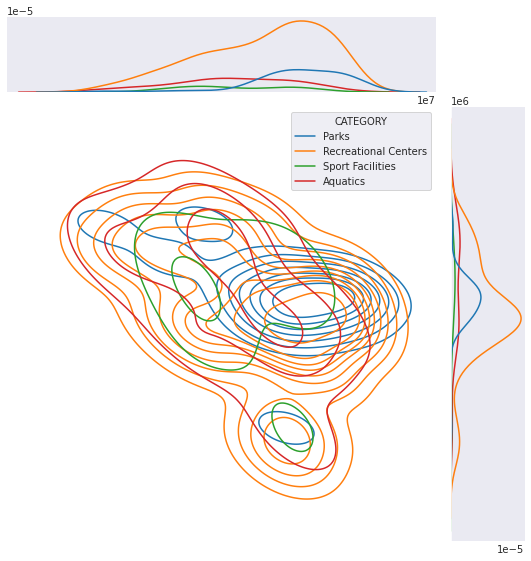

In [588]:
# multiple kde plots by park type
g = sns.jointplot(data = parkpoints,
              x='x', 
              y='y', 
              kind='kde',
              hue='CATEGORY',
              height=8 # make the map bigger
                 )

# Clean axes
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

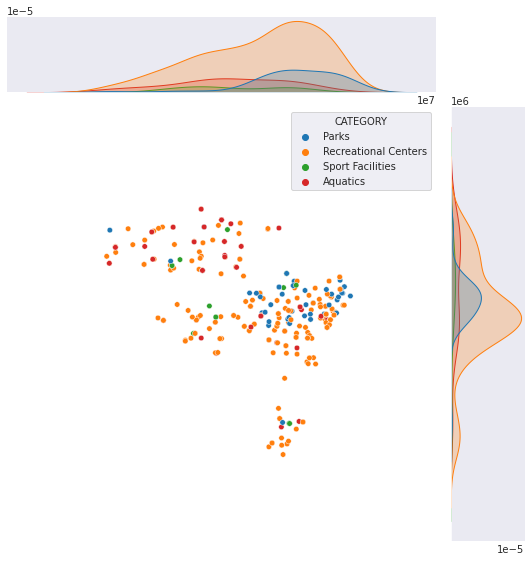

In [589]:
# color code park points by category
g = sns.jointplot(data = parkpoints,
                  x='x', 
                  y='y',
                  hue='CATEGORY',
                  s=30,
                  height=8 # make the map bigger
                 )

# Clean axes
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


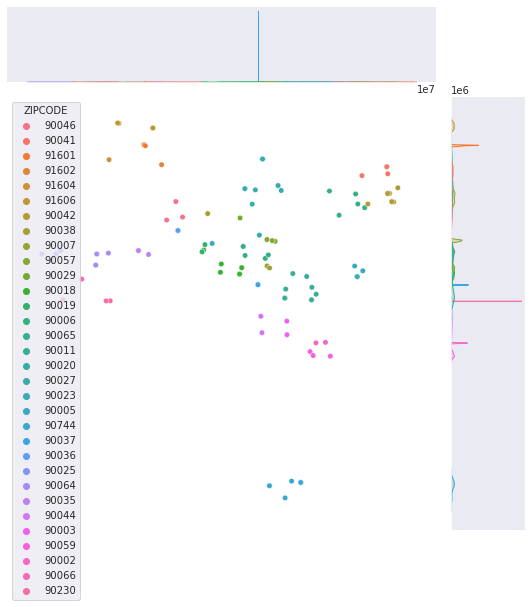

In [590]:
# color code park points by zip code
g = sns.jointplot(data = join2,
                  x='x', 
                  y='y',
                  hue='ZIPCODE',
                  s=30,
                  height=8 # make the map bigger
                 )

# Clean axes
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [591]:
# compute the mean and median centers
mean_center = centrography.mean_center(parkpoints[['x','y']])
med_center = centrography.euclidean_median(parkpoints[['x','y']])

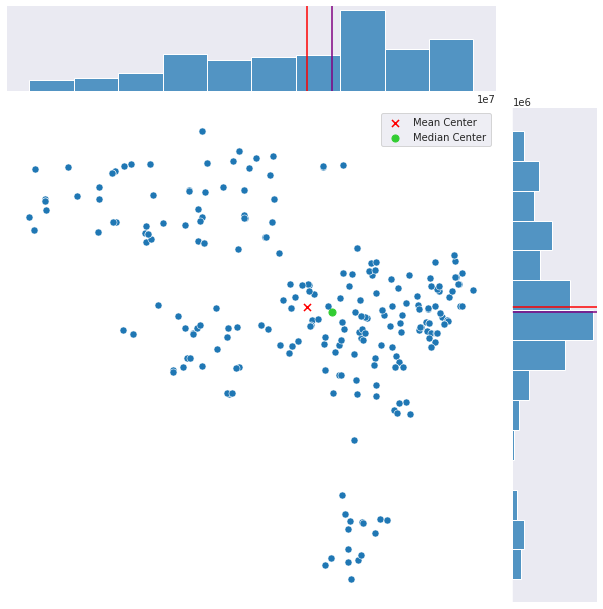

In [592]:
# Generate scatter plot
g = sns.jointplot(
    x='x', y='y', data=parkpoints, s=50, height=9
)

# Add mean point and marginal lines
g.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
g.ax_marg_x.axvline(mean_center[0], color='red')
g.ax_marg_y.axhline(mean_center[1], color='red')

# Add median point and marginal lines
g.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
g.ax_marg_x.axvline(med_center[0], color='purple')
g.ax_marg_y.axhline(med_center[1], color='purple')

# Legend
g.ax_joint.legend()

# Clean axes
g.ax_joint.set_axis_off()

# Display
plt.show()

In [593]:
major, minor, rotation = centrography.ellipse(parkpoints[['x','y']])

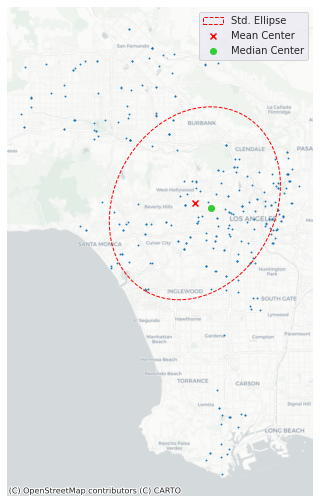

In [594]:
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot points
ax.scatter(parkpoints['x'], parkpoints['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', 
                  linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Display
plt.show()